In [1]:
import json
import requests
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt  # matplotlib is not installed automatically
from datetime import datetime
import warnings
warnings.filterwarnings("ignore")

In [2]:
network_name = 'various-geographic-locations'
# network_name = 'California'

home_dir = r"G:\Araki\SMSigxSMAP"
input_path = r"1_data"
appeears_path = r"APPEEARS_subsetting"
SMAPL3_path = r"SPL3SMP_E"
SMAPL4_path = r"SPL4SMGP"
SMAPL4_grid_path = r"SMAPL4SMGP_EASEreference"
MODIS_path = r"MOD15A2H"
PET_path = r"PET"

output_path = r"3_data_out\exp_plots"

## Read and process data

### Request json

In [3]:
file_path = os.path.join(home_dir, input_path, appeears_path, network_name, f'{network_name}-request.json')
with open(file_path, 'r') as infile:
    request_content = json.load(infile)

coordinates = request_content['params']['coordinates']
print(len(coordinates))
coordinate = 9
target_lat = coordinates[coordinate]['latitude']
target_lon = coordinates[coordinate]['longitude']
target_station = coordinates[coordinate]['category']
print(f'Currently processing station: {target_station}')

output_path2 = os.path.join(home_dir, output_path, target_station)
if not os.path.exists(output_path2):
    os.makedirs(output_path2)


# succsss: ["Central_valley", "China (Mid-lat humid)", "South Dacota (Mid-lat dry)", "Argentina (Mid-lat dry)", "Russia (Mid-lat humid)"]

10
Currently processing station: Russia (Mid-lat humid)


### SMAP L3

In [4]:
file_path = os.path.join(home_dir, input_path, appeears_path, network_name, f'{network_name}-SPL3SMP-E-005-results.csv')
SMAPL3_pt_sample = pd.read_csv(file_path)
SMAPL3_pt_sample = SMAPL3_pt_sample[(SMAPL3_pt_sample['Latitude'] == target_lat) & (SMAPL3_pt_sample['Longitude'] == target_lon)].copy()

df_ts_smap_am = SMAPL3_pt_sample[['Date', 'SPL3SMP_E_005_Soil_Moisture_Retrieval_Data_AM_soil_moisture','SPL3SMP_E_005_Soil_Moisture_Retrieval_Data_AM_retrieval_qual_flag']].copy()
df_ts_smap_am['Date'] = pd.to_datetime(df_ts_smap_am['Date'])
df_ts_smap_am.set_index('Date', inplace=True)
bad_data_idx_smap = df_ts_smap_am[(df_ts_smap_am['SPL3SMP_E_005_Soil_Moisture_Retrieval_Data_AM_retrieval_qual_flag'] != 0.0) & (df_ts_smap_am['SPL3SMP_E_005_Soil_Moisture_Retrieval_Data_AM_retrieval_qual_flag'] != 8.0)].index
df_ts_smap_am.drop(bad_data_idx_smap, inplace=True)
df_ts_smap_am_daily = df_ts_smap_am['SPL3SMP_E_005_Soil_Moisture_Retrieval_Data_AM_soil_moisture'].resample('D', axis=0).mean()

df_ts_smap_pm = SMAPL3_pt_sample[['Date', 'SPL3SMP_E_005_Soil_Moisture_Retrieval_Data_PM_soil_moisture_pm','SPL3SMP_E_005_Soil_Moisture_Retrieval_Data_PM_retrieval_qual_flag_pm']].copy()
df_ts_smap_pm['Date'] = pd.to_datetime(df_ts_smap_pm['Date'])
df_ts_smap_pm.set_index('Date', inplace=True)
bad_data_idx_smap = df_ts_smap_pm[(df_ts_smap_pm['SPL3SMP_E_005_Soil_Moisture_Retrieval_Data_PM_retrieval_qual_flag_pm'] != 0.0) & (df_ts_smap_pm['SPL3SMP_E_005_Soil_Moisture_Retrieval_Data_PM_retrieval_qual_flag_pm'] != 8.0)].index
df_ts_smap_pm.drop(bad_data_idx_smap, inplace=True)
df_ts_smap_pm_daily = df_ts_smap_pm['SPL3SMP_E_005_Soil_Moisture_Retrieval_Data_PM_soil_moisture_pm'].resample('D', axis=0).mean()

df_ts_sync = pd.merge(df_ts_smap_am_daily, df_ts_smap_pm_daily, how='inner', left_index=True, right_index=True)
df_ts_sync['soil_moisture_smapL3'] = df_ts_sync[['SPL3SMP_E_005_Soil_Moisture_Retrieval_Data_AM_soil_moisture','SPL3SMP_E_005_Soil_Moisture_Retrieval_Data_PM_soil_moisture_pm']].mean(axis=1, skipna=True)
df_ts_sync['soil_moisture_smapL3'] = df_ts_sync['soil_moisture_smapL3'].resample('D', axis=0).mean()

### SMAPL4

In [5]:
file_path = os.path.join(home_dir, input_path, appeears_path, network_name, f'{network_name}-P-SPL4SMGP-006-results.csv')
SMAPL4_pt_sample = pd.read_csv(file_path)
SMAPL4_pt_sample = SMAPL4_pt_sample[(SMAPL4_pt_sample['Latitude'] == target_lat) & (SMAPL4_pt_sample['Longitude'] == target_lon)].copy()

# print(SMAPL4_pt_sample.columns)

# SMAPL4_pt_sample[['SPL4SMGP_006_Geophysical_Data_precipitation_total_surface_flux_0', 
#                   'SPL4SMGP_006_Geophysical_Data_precipitation_total_surface_flux_1',
#                   'SPL4SMGP_006_Geophysical_Data_precipitation_total_surface_flux_2',
#                   'SPL4SMGP_006_Geophysical_Data_precipitation_total_surface_flux_3',
#                   'SPL4SMGP_006_Geophysical_Data_precipitation_total_surface_flux_4',
#                   'SPL4SMGP_006_Geophysical_Data_precipitation_total_surface_flux_5',
#                   'SPL4SMGP_006_Geophysical_Data_precipitation_total_surface_flux_6',
#                   'SPL4SMGP_006_Geophysical_Data_precipitation_total_surface_flux_7']].plot()

# ? Where is data converted to daily from hourly? 

df_ts_smap_precip = SMAPL4_pt_sample[['Date', 'SPL4SMGP_006_Geophysical_Data_precipitation_total_surface_flux_0']].copy()
df_ts_smap_precip = df_ts_smap_precip.rename({'SPL4SMGP_006_Geophysical_Data_precipitation_total_surface_flux_0': 'precip'}, axis='columns')
df_ts_smap_precip['Date'] = pd.to_datetime(df_ts_smap_precip['Date'])
df_ts_smap_precip.set_index('Date', inplace=True)
df_ts_smap_precip


,precip
Date,
2015-03-31,2.200000e-06
2015-04-01,2.000000e-07
2015-04-02,3.300000e-06
2015-04-03,2.200000e-06
2015-04-04,2.000000e-07
...,...
2022-04-26,0.000000e+00
2022-04-27,0.000000e+00
2022-04-28,0.000000e+00


Convert precipitation from kg/m2/s to mm/day -> 1 kg/m2/s = 86400 mm/day

In [6]:
df_ts_smap_precip = df_ts_smap_precip * 86400

In [7]:
df_ts_sync = pd.merge(df_ts_sync, df_ts_smap_precip, how='inner', left_index=True, right_index=True)

noprecip = df_ts_smap_precip['precip'] < 0.00002
df_ts_sync['noprecip'] = noprecip

df_ts_sync.head()

,SPL3SMP_E_005_Soil_Moisture_Retrieval_Data_AM_soil_moisture,SPL3SMP_E_005_Soil_Moisture_Retrieval_Data_PM_soil_moisture_pm,soil_moisture_smapL3,precip,noprecip
Date,,,,,
2015-04-17,0.554210,0.557213,0.555711,0.00000,True
2015-04-18,0.593589,0.546979,0.570284,0.05184,False
2015-04-19,NaN,0.583060,0.583060,0.56160,False
2015-04-20,0.570953,NaN,0.570953,20.31264,False
2015-04-21,0.572359,0.608136,0.590248,0.09504,False


<Axes: xlabel='Date'>

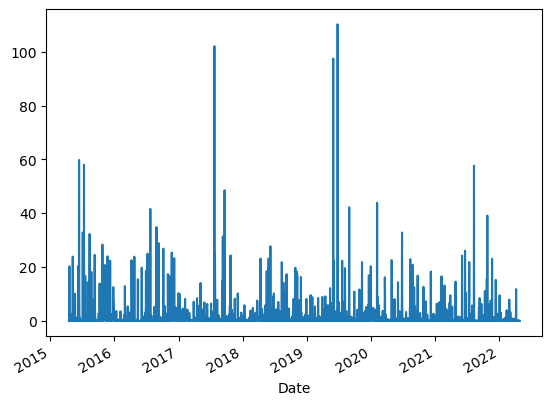

In [8]:
df_ts_sync['precip'].plot()

### PET

Get the point-sampled PET data beforehand by running '0_code\singerPET_create_datarods_v3.py'

In [9]:
file_path = os.path.join(home_dir, input_path, PET_path, target_station)
file_list = os.listdir(file_path)

print(file_list)
PET = pd.read_csv(os.path.join(file_path, file_list[0]), header=None)
day_num = PET.index.to_numpy()
year = file_list[0][-8:-4]
PET['Date'] = pd.to_datetime(PET.index, unit='D', origin=pd.Timestamp(year))
PET.set_index('Date', inplace=True)

for i, file in enumerate(file_list):
    PET = pd.read_csv(os.path.join(file_path, file), header=None)
    year = file[-8:-4]
    PET['Date'] = pd.to_datetime(PET.index, unit='D', origin=pd.Timestamp(year))
    PET.set_index('Date', inplace=True)
    if i==0:
        ds_PET = PET
    else:
        ds_PET = pd.concat([ds_PET, PET])
ds_PET = ds_PET.sort_index()
ds_PET = ds_PET.rename(columns = {0:'PET'})
ds_PET

['dPET_2015.txt', 'dPET_2016.txt', 'dPET_2017.txt', 'dPET_2018.txt', 'dPET_2019.txt', 'dPET_2020.txt', 'dPET_2021.txt']


,PET
Date,
2015-01-01,0.09675
2015-01-02,0.07754
2015-01-03,0.01556
2015-01-04,0.27014
2015-01-05,0.23364
...,...
2021-12-27,0.10050
2021-12-28,0.12797
2021-12-29,0.05786


In [10]:
ds_synced = pd.merge(df_ts_sync[['soil_moisture_smapL3', 'precip']], ds_PET, how='inner', left_index=True, right_index=True)
ds_synced = ds_synced.rename({'soil_moisture_smapL3': 'soil_moisture_daily'}, axis='columns')
ds_synced

,soil_moisture_daily,precip,PET
Date,,,
2015-04-17,0.555711,0.00000,3.13358
2015-04-18,0.570284,0.05184,1.23807
2015-04-19,0.583060,0.56160,2.37805
2015-04-20,0.570953,20.31264,0.85697
2015-04-21,0.590248,0.09504,3.37543
...,...,...,...
2021-12-27,NaN,0.07776,0.10050
2021-12-28,NaN,0.83808,0.12797
2021-12-29,NaN,0.02592,0.05786


## Calculate dSdt

In [11]:
# Thresholds
lower_quantile_thresh = 0.25
upper_quantile_thresh = 0.75
precip_thresh = 0.00002

In [67]:
precip_mask = ds_synced['precip'].where(ds_synced['precip'] < precip_thresh)
no_sm_record_but_precip_present = ds_synced['precip'].where((precip_mask.isnull()) & (ds_synced['soil_moisture_daily'].isnull()))
# ds_synced['sm_for_dS_calc'] = ds_synced['soil_moisture_daily'].where(no_sm_record_but_precip_present.isnull(), 9999)

# Allow detecting soil moisture increment even if there is no SM data in between before/after rainfall event
# NaN data is allowed up to 10 days
ds_synced['sm_for_dS_calc'] = ds_synced['soil_moisture_daily'].ffill(limit=10) 

In [34]:
# Calculate dS
ds_synced['dS'] = ds_synced['sm_for_dS_calc'].bfill(limit=5).diff().where(ds_synced['sm_for_dS_calc'].notnull().shift(periods=+1))

# Drop the dS where  (precipitation is present) && (soil moisture record does not exist)
ds_synced['dS'] = ds_synced['dS'].where((ds_synced['dS'] > -1) & (ds_synced['dS'] < 1))

# Calculate dt
non_nulls = ds_synced['sm_for_dS_calc'].isnull().cumsum()
nan_length = non_nulls.where(ds_synced['sm_for_dS_calc'].notnull()).bfill()+1 - non_nulls +1
ds_synced['dt'] = nan_length.where(ds_synced['sm_for_dS_calc'].isnull()).fillna(1)

# Calculate dS/dt
ds_synced['dSdt'] = ds_synced['dS']/ds_synced['dt']
ds_synced['dSdt'] = ds_synced['dSdt'].shift(periods=-1)


In [63]:
ds_synced.loc[ds_synced['soil_moisture_daily'].shift(-1).isna(), 'dSdt'] = np.nan

In [36]:
ds_synced.head()

,soil_moisture_daily,precip,PET,sm_for_dS_calc,dS,dt,dSdt,event_start,event_end
Date,,,,,,,,,
2015-04-17,0.555711,0.00000,3.13358,0.555711,NaN,1.0,0.014572,False,False
2015-04-18,0.570284,0.05184,1.23807,0.570284,0.014572,1.0,0.012777,False,False
2015-04-19,0.583060,0.56160,2.37805,0.583060,0.012777,1.0,-0.012107,False,False
2015-04-20,0.570953,20.31264,0.85697,0.570953,-0.012107,1.0,0.019294,False,False
2015-04-21,0.590248,0.09504,3.37543,0.590248,0.019294,1.0,-0.010857,False,False


## Detect significant peak

Adapt https://agupubs.onlinelibrary.wiley.com/doi/10.1002/2017GL072819


- Any positive increment smaller than 5% of the observed range of soil moisture at the site is excluded if it would otherwise truncate a drydown. 
- To avoid noise creating spurious drydowns, identified drydowns were excluded from the analysis when the positive increment preceding the drydown was less than two times the target unbiased root-mean-square difference for SMAP observations (0.08). 
- Of the remaining drydowns, only those that contained more than four SMAP observations were retained.

In [37]:
# Any positive increment smaller than 5% of the observed range of soil moisture at the site is excluded if it would otherwise truncate a drydown. 
dSdt_thresh = (ds_synced.soil_moisture_daily.max() - ds_synced.soil_moisture_daily.min()) * 0.05

# To avoid noise creating spurious drydowns, identified drydowns were excluded from the analysis when the positive increment preceding the drydown was less than two times the target unbiased root-mean-square difference for SMAP observations (0.08).
target_rmsd = 0.08
dSdt_thresh

0.027939492500000003

In [64]:
ds_synced.head(15)

,soil_moisture_daily,precip,PET,sm_for_dS_calc,dS,dt,dSdt,event_start,event_end,dSdt(t-1)
Date,,,,,,,,,,
2015-04-17,0.555711,0.00000,3.13358,0.555711,NaN,1.0,0.014572,False,False,NaN
2015-04-18,0.570284,0.05184,1.23807,0.570284,0.014572,1.0,0.012777,False,False,0.014572
2015-04-19,0.583060,0.56160,2.37805,0.583060,0.012777,1.0,-0.012107,False,False,0.012777
2015-04-20,0.570953,20.31264,0.85697,0.570953,-0.012107,1.0,0.019294,False,False,-0.012107
2015-04-21,0.590248,0.09504,3.37543,0.590248,0.019294,1.0,-0.010857,False,False,0.019294
2015-04-22,0.579391,0.00864,2.54867,0.579391,-0.010857,1.0,-0.011580,False,False,-0.010857
2015-04-23,0.567811,0.38880,1.83308,0.567811,-0.011580,1.0,0.017869,False,False,-0.011580
2015-04-24,0.585680,0.00000,2.89980,0.585680,0.017869,1.0,-0.021588,False,False,0.017869
2015-04-25,0.564092,0.16416,2.39806,0.564092,-0.021588,1.0,-0.043944,False,False,-0.021588


In [65]:
start_date = pd.to_datetime('2018-06-22')
end_date = pd.to_datetime('2018-07-04')
ds_synced.loc[start_date:end_date]


,soil_moisture_daily,precip,PET,sm_for_dS_calc,dS,dt,dSdt,event_start,event_end,dSdt(t-1)
Date,,,,,,,,,,
2018-06-22,0.425938,0.00000,3.20353,0.425938,0.056833,1.0,-0.070024,False,False,0.056833
2018-06-23,0.355914,1.40832,3.12177,0.355914,-0.070024,1.0,0.005363,False,False,-0.070024
2018-06-24,0.361278,1.37376,3.41030,0.361278,0.005363,1.0,-0.028714,False,False,0.005363
2018-06-25,0.332563,0.66528,3.51520,0.332563,-0.028714,1.0,0.016275,False,False,-0.028714
2018-06-26,0.348838,9.28800,2.34122,0.348838,0.016275,1.0,NaN,False,False,0.016275
2018-06-27,NaN,0.06048,3.86176,0.348838,0.000000,1.0,0.048223,False,False,0.000000
2018-06-28,0.397061,10.25568,3.02185,0.397061,0.048223,1.0,-0.011723,False,False,0.048223
2018-06-29,0.385338,0.12960,3.34601,0.385338,-0.011723,1.0,0.007110,False,False,-0.011723
2018-06-30,0.392448,0.95904,2.73437,0.392448,0.007110,1.0,-0.035903,False,False,0.007110


In [40]:
negative_increments = ds_synced.dSdt < 0

# To avoid noise creating spurious drydowns, identified drydowns were excluded from the analysis when the positive increment preceding the drydown was less than two times the target unbiased root-mean-square difference for SMAP observations (0.08).
positive_increments = ds_synced.dSdt > target_rmsd
print(positive_increments[start_date:end_date])
print(negative_increments[start_date:end_date])

Date
2018-06-22    False
2018-06-23    False
2018-06-24    False
2018-06-25    False
2018-06-26    False
2018-06-27    False
2018-06-28    False
2018-06-29    False
2018-06-30    False
2018-07-01    False
2018-07-02    False
2018-07-03    False
2018-07-04    False
Name: dSdt, dtype: bool
Date
2018-06-22     True
2018-06-23    False
2018-06-24     True
2018-06-25    False
2018-06-26    False
2018-06-27    False
2018-06-28     True
2018-06-29    False
2018-06-30     True
2018-07-01     True
2018-07-02    False
2018-07-03     True
2018-07-04     True
Name: dSdt, dtype: bool


In [41]:

# positive_increments = ds_synced.dS.ffill() > target_rmsd
# TODO: NOT lose drydown starting after NaN

# Negative dSdt preceded with positive dSdt
ds_synced['event_start'] = negative_increments.values & np.concatenate(([False], positive_increments[:-1]))
ds_synced['event_start'][ds_synced['event_start']].index

# drydown_indices = ds_synced.index[negative_increments & pd.Series(np.concatenate(([False], positive_increments[:-1])), index=ds_synced.index)]
# drydown_indices
# sum(negative_increments.values & np.concatenate(([False], positive_increments[:-1])))

DatetimeIndex(['2016-05-25', '2016-08-11', '2017-05-06', '2017-05-21',
               '2017-07-24', '2017-08-06', '2018-04-23', '2018-05-26',
               '2018-05-29', '2018-10-22', '2019-04-10', '2019-11-02',
               '2021-04-16', '2021-06-04', '2021-07-13'],
              dtype='datetime64[ns]', name='Date', freq=None)

In [42]:
# # iterate through each row to find event end
# precip_thresh = 2
# event_end = np.zeros(ds_synced.shape[0], dtype=bool)
# ds_synced['dS'] = ds_synced['dS'].shift(-1)
# for i in range(1, ds_synced.shape[0]):
#     if ds_synced['event_start'][i]:
#         start_index = i
#         for j in range(i+1, ds_synced.shape[0]):
#             if np.isnan(ds_synced['dS'][j]):
#                 continue
#             if ds_synced['dS'][j] >= dSdt_thresh or ds_synced['precip'][j] > precip_thresh:
#                 event_end[j] = True
#                 break

# # create a new column for event_end
# ds_synced['event_end'] = event_end
# iterate through each row to find event end
precip_thresh = 2
event_end = np.zeros(ds_synced.shape[0], dtype=bool)
# ds_synced['dS'] = ds_synced['dS'].shift(-1)
for i in range(1, ds_synced.shape[0]):
    if ds_synced['event_start'][i]:
        start_index = i
        for j in range(i+1, ds_synced.shape[0]):
            if np.isnan(ds_synced['dS'][j]):
                None
            if ds_synced['dS'][j] >= dSdt_thresh or ds_synced['precip'][j] > precip_thresh:
                # Any positive increment smaller than 5% of the observed range of soil moisture at the site is excluded (if there is not precipitation) if it would otherwise truncate a drydown. 
                event_end[j] = True
                break

# create a new column for event_end
ds_synced['event_end'] = event_end
ds_synced['event_end'] = ds_synced['event_end'].shift(-1)
ds_synced = ds_synced[:-1]

In [43]:
ds_synced['event_start'][ds_synced['event_start']].index

DatetimeIndex(['2016-05-25', '2016-08-11', '2017-05-06', '2017-05-21',
               '2017-07-24', '2017-08-06', '2018-04-23', '2018-05-26',
               '2018-05-29', '2018-10-22', '2019-04-10', '2019-11-02',
               '2021-04-16', '2021-06-04', '2021-07-13'],
              dtype='datetime64[ns]', name='Date', freq=None)

In [44]:
ds_synced['event_start'][ds_synced['event_end']].index

DatetimeIndex(['2016-05-31', '2016-08-15', '2017-05-07', '2017-05-23',
               '2017-07-26', '2017-08-06', '2018-04-29', '2018-05-28',
               '2018-05-31', '2018-10-27', '2019-04-13', '2019-11-06',
               '2021-04-20', '2021-06-19', '2021-07-13'],
              dtype='datetime64[ns]', name='Date', freq=None)

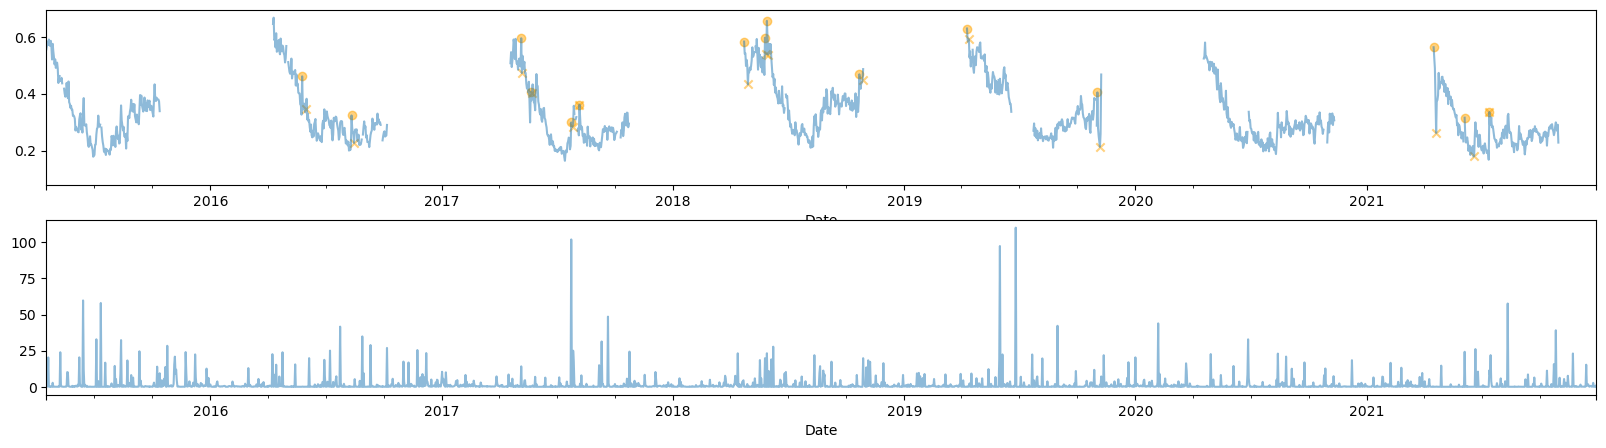

In [45]:
fig, (ax11, ax12) = plt.subplots(2,1, figsize=(20, 5))
ds_synced.soil_moisture_daily.plot(ax=ax11, alpha=0.5)
ax11.scatter(ds_synced.soil_moisture_daily[ds_synced['event_start']].index, ds_synced.soil_moisture_daily[ds_synced['event_start']].values, color='orange', alpha=0.5)
ax11.scatter(ds_synced.soil_moisture_daily[ds_synced['event_end']].index, ds_synced.soil_moisture_daily[ds_synced['event_end']].values, color='orange', marker='x', alpha=0.5)
ds_synced.precip.plot(ax=ax12, alpha=0.5)
fig.savefig(os.path.join(output_path2, f'{target_station}_timeseries.png'))


(17897.0, 18260.0)

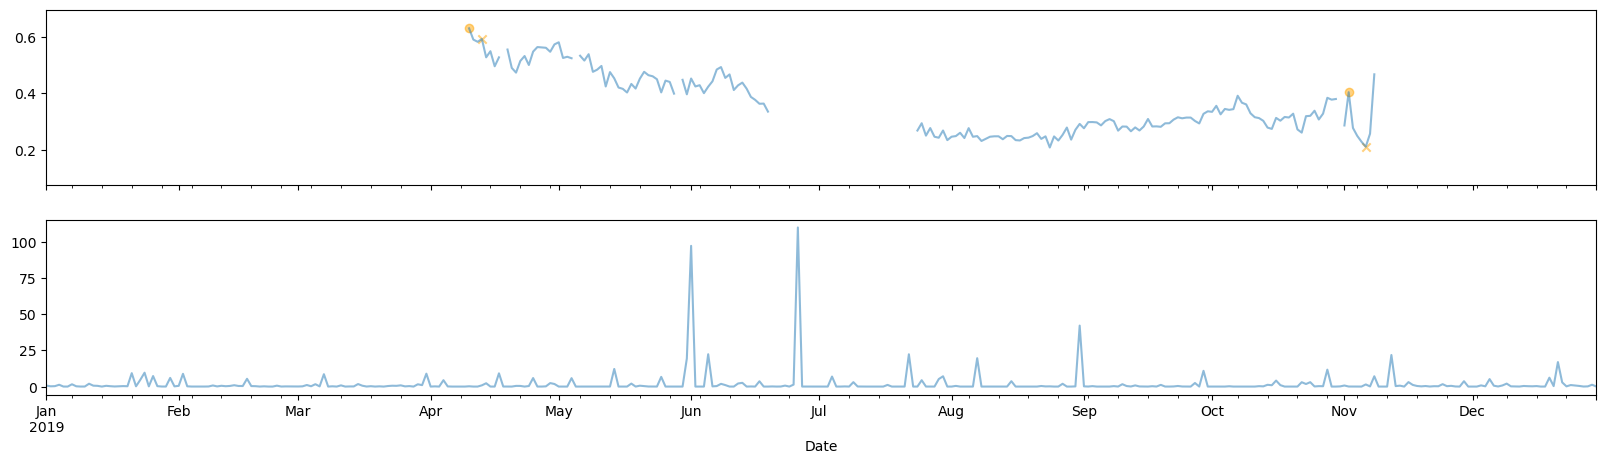

In [59]:
fig2, (ax21, ax22) = plt.subplots(2,1, figsize=(20, 5), sharex=True)
ds_synced.soil_moisture_daily.plot(ax=ax21, alpha=0.5)
ax21.scatter(ds_synced.soil_moisture_daily[ds_synced['event_start']].index, ds_synced.soil_moisture_daily[ds_synced['event_start']].values, color='orange', alpha=0.5)
ax21.scatter(ds_synced.soil_moisture_daily[ds_synced['event_end']].index, ds_synced.soil_moisture_daily[ds_synced['event_end']].values, color='orange', marker='x', alpha=0.5)
ds_synced.precip.plot(ax=ax22, alpha=0.5)
ax22.set_xlim([datetime(2019, 1, 1), datetime(2019, 12, 30)])

In [48]:
ds_synced['dSdt(t-1)'] = ds_synced.dSdt.shift(+1)
ds_synced.head(10)

,soil_moisture_daily,precip,PET,sm_for_dS_calc,dS,dt,dSdt,event_start,event_end,dSdt(t-1)
Date,,,,,,,,,,
2015-04-17,0.555711,0.00000,3.13358,0.555711,NaN,1.0,0.014572,False,False,NaN
2015-04-18,0.570284,0.05184,1.23807,0.570284,0.014572,1.0,0.012777,False,False,0.014572
2015-04-19,0.583060,0.56160,2.37805,0.583060,0.012777,1.0,-0.012107,False,False,0.012777
2015-04-20,0.570953,20.31264,0.85697,0.570953,-0.012107,1.0,0.019294,False,False,-0.012107
2015-04-21,0.590248,0.09504,3.37543,0.590248,0.019294,1.0,-0.010857,False,False,0.019294
2015-04-22,0.579391,0.00864,2.54867,0.579391,-0.010857,1.0,-0.011580,False,False,-0.010857
2015-04-23,0.567811,0.38880,1.83308,0.567811,-0.011580,1.0,0.017869,False,False,-0.011580
2015-04-24,0.585680,0.00000,2.89980,0.585680,0.017869,1.0,-0.021588,False,False,0.017869
2015-04-25,0.564092,0.16416,2.39806,0.564092,-0.021588,1.0,-0.043944,False,False,-0.021588


## Separate into events

In [49]:
start_indices = ds_synced[ds_synced['event_start']].index
end_indices = ds_synced[ds_synced['event_end']].index

# Create a new DataFrame with each row containing a list of soil moisture values between each pair of event_start and event_end
event_data = [{'event_start': start_index, 
               'event_end': end_index, 
               'soil_moisture_daily': list(ds_synced.loc[start_index:end_index, 'soil_moisture_daily'].values),
               'precip': list(ds_synced.loc[start_index:end_index, 'precip'].values),
               'PET': list(ds_synced.loc[start_index:end_index, 'PET'].values),
               'delta_theta': ds_synced.loc[start_index, 'dSdt(t-1)']
               } 
               for start_index, end_index in zip(start_indices, end_indices)]
event_df = pd.DataFrame(event_data)

In [50]:
event_df_long = event_df[event_df['soil_moisture_daily'].apply(lambda x: pd.notna(x).sum()) >= 4].copy()
event_df_long = event_df_long.reset_index(drop=True)
event_df_long


,event_start,event_end,soil_moisture_daily,precip,PET,delta_theta
0,2016-05-25,2016-05-31,"[0.4609129, 0.35893575, 0.3447153, nan, 0.3646...","[0.03456, 0.12096, 0.0, 0.01728, 0.00864, 0.02...","[4.43224, 4.92909, 4.73209, 3.13189, 4.1635, 2...",0.134515
1,2016-08-11,2016-08-15,"[0.323529, 0.2811533, 0.26178239999999997, 0.2...","[0.06912, 0.03456, 0.00864, 0.0, 0.0]","[2.73083, 3.83021, 4.02038, 3.23113, 3.52812]",0.106651
2,2018-04-23,2018-04-29,"[0.5828828, 0.539686, 0.54222545, 0.4972738, 0...","[0.043199999999999995, 0.20736, 0.0, 0.02592, ...","[1.46024, 2.29119, 2.18556, 1.97967, 3.31286, ...",0.311689
3,2018-10-22,2018-10-27,"[0.46805359999999996, 0.4302682, 0.4171469, 0....","[0.21600000000000003, 0.02592, 0.0, 0.0, 0.0, ...","[0.73919, 0.65516, 0.77582, 0.78138, 1.2496, 1...",0.096717
4,2019-04-10,2019-04-13,"[0.6289516, 0.5893305, 0.5816038, 0.59140305]","[0.19872, 0.0, 0.0, 0.85536]","[2.15359, 2.50336, 3.33678, 2.91455]",0.142593
5,2019-11-02,2019-11-06,"[0.404529, 0.27894355000000004, 0.2512322, 0.2...","[0.03456, 0.0, 0.0, 0.0, 1.4774399999999999]","[0.807, 0.57693, 0.32473, 0.4193, 0.61903]",0.116840
6,2021-04-16,2021-04-20,"[0.5631202, 0.5258303, 0.4891295, 0.3836832, 0...","[0.0, 0.0, 0.06048, 0.00864, 0.03456]","[2.42385, 2.37172, 1.88156, 1.90795, 2.26146]",0.256443
7,2021-06-04,2021-06-19,"[0.31570375, 0.24851420000000002, 0.228517, 0....","[24.21792, 0.0, 0.0, 0.0, 0.5616, 0.0, 0.0, 0....","[2.80599, 5.08933, 6.13704, 5.88463, 4.43908, ...",0.083307


## Calculate tau

In [51]:
from scipy.optimize import curve_fit
from scipy.stats import norm
from scipy.optimize import minimize

In [52]:
# Function for exponential model
def exp_model(t, delta_theta, theta_w, tau):
    return delta_theta * np.exp(-t/tau) + theta_w

def neg_log_likelihood(params, t, y):
    delta_theta, theta_w, tau, sigma = params
    y_hat = exp_model(t, delta_theta, theta_w, tau)
    residuals = y - y_hat
    ssr = np.sum(residuals ** 2)
    n = len(y)
    sigma2 = ssr / n
    ll = -(n / 2) * np.log(2 * np.pi * sigma2) - (1 / (2 * sigma2)) * ssr
    return -ll


In [53]:
min_sm_values_at_the_pt = df_ts_sync.soil_moisture_smapL3.min()
min_sm_values_at_the_pt

0.10821625

In [54]:
# Fit exponential model to each drydown event

opt_model = 'OLSE'
# opt_model = 'MLE'
drydown_params = []
for index, row in event_df_long.iterrows():
    start_date = row['event_start']
    end_date = row['event_end']
    delta_theta = row['delta_theta']
    soil_moisture_subset = np.asarray(row['soil_moisture_daily'])
    t = np.arange(0, len(soil_moisture_subset),1)
    soil_moisture_range = np.nanmax(soil_moisture_subset) - np.nanmin(soil_moisture_subset)
    soil_moisture_subset_min = np.nanmin(soil_moisture_subset)
    soil_moisture_subset_max = np.nanmax(soil_moisture_subset)
    x = t[~np.isnan(soil_moisture_subset)]
    y = soil_moisture_subset[~np.isnan(soil_moisture_subset)]
    #       delta_theta, theta_w, tau, sigma
    
    if opt_model == "MLE":
        bounds  = ((0, 2*soil_moisture_range), (min_sm_values_at_the_pt, soil_moisture_subset_min), (0, np.inf), (0, np.inf))
        p0      = [0.5*soil_moisture_subset_max, 2*soil_moisture_subset_min, 1, 0.1]
        res = minimize(neg_log_likelihood, p0, args=(t[~np.isnan(soil_moisture_subset)], soil_moisture_subset[~np.isnan(soil_moisture_subset)]), bounds=bounds, method='L-BFGS-B')
        popt = res.x
        if res.success and res.fun < 0:
            drydown_params.append({'event_start': start_date, 'event_end': end_date, 'delta_theta': popt[0], 'theta_w': popt[1], 'tau': popt[2]})
    elif opt_model == 'OLSE':
        # exp_model(t, delta_theta, theta_w, tau):
        bounds  = [(0, min_sm_values_at_the_pt, 0), (2*soil_moisture_range, soil_moisture_subset_min, np.inf)]
        p0      = [0.5*soil_moisture_range, (soil_moisture_subset_min+min_sm_values_at_the_pt)/2, 1]
        try: 
            popt, pcov = curve_fit(f=exp_model, xdata=x, ydata=y, p0=p0, bounds=bounds)
            # popt: Optimal values for the parameters so that the sum of the squared residuals of f(xdata, *popt) - ydata is minimized
            # pcov: The estimated covariance of popt
            y_opt = exp_model(x, *popt)
            residuals = y - y_opt
            ss_res = np.sum(residuals ** 2)
            ss_tot = np.sum((y - np.nanmean(y)) ** 2)
            r_squared = 1 - (ss_res / ss_tot)

            drydown_params.append({'event_start': start_date, 'event_end': end_date, 'delta_theta': popt[0], 'theta_w': popt[1], 'tau': popt[2], 'r_squared': r_squared, 'opt_drydown': y_opt.tolist()})
        except:
            print('Error raised')
            continue

# Convert drydown parameters to DataFrame
drydown_params_df = pd.DataFrame(drydown_params)
drydown_params
# # Only retain drydown events with R2 >= 0.7
# r_squared_threshold = 0.7
# drydown_events_r2 = []
# for index, row in drydown_params_df.iterrows():
#     start_date = row['start_date']
#     end_date = row['end_date']
#     soil_moisture_subset = soil_moisture_daily[start_date:end_date]
#     x = (soil_moisture_subset.index - start_date).days
#     y = soil_moisture_subset['soil_moisture']
#     popt, pcov = curve_fit(exp_model, x, y, p0=[row['delta_theta'], row['theta_w'], row['tau']])
#     residuals = y - exp_model(x, *popt)
#     ss_res = np.sum(res


[{'event_start': Timestamp('2016-05-25 00:00:00'),
  'event_end': Timestamp('2016-05-31 00:00:00'),
  'delta_theta': 0.1259978962939285,
  'theta_w': 0.33450469999999993,
  'tau': 0.6576412330714353,
  'r_squared': 0.9062547667288358,
  'opt_drydown': [0.4605025962939284,
   0.3620457960187821,
   0.3405247367801881,
   0.3347923305390867,
   0.3345675713695063,
   0.33451844266138825]},
 {'event_start': Timestamp('2016-08-11 00:00:00'),
  'event_end': Timestamp('2016-08-15 00:00:00'),
  'delta_theta': 0.1175550801286231,
  'theta_w': 0.20336310408946764,
  'tau': 2.9766145119734877,
  'r_squared': 0.9493258795075508,
  'opt_drydown': [0.32091818421809076,
   0.28737470168475,
   0.26340260661704185,
   0.24627077358914887,
   0.23402738384508906]},
 {'event_start': Timestamp('2018-04-23 00:00:00'),
  'event_end': Timestamp('2018-04-29 00:00:00'),
  'delta_theta': 0.3008913999999736,
  'theta_w': 0.2774659844931142,
  'tau': 12.20943122876043,
  'r_squared': 0.8149147432369461,
  'opt_

In [55]:
event_df_with_curvefit = pd.merge(event_df_long, drydown_params_df.drop(columns='delta_theta'), on=['event_start', 'event_end'], how='outer')
event_df_with_curvefit

,event_start,event_end,soil_moisture_daily,precip,PET,delta_theta,theta_w,tau,r_squared,opt_drydown
0,2016-05-25,2016-05-31,"[0.4609129, 0.35893575, 0.3447153, nan, 0.3646...","[0.03456, 0.12096, 0.0, 0.01728, 0.00864, 0.02...","[4.43224, 4.92909, 4.73209, 3.13189, 4.1635, 2...",0.134515,0.334505,0.657641,0.906255,"[0.4605025962939284, 0.3620457960187821, 0.340..."
1,2016-08-11,2016-08-15,"[0.323529, 0.2811533, 0.26178239999999997, 0.2...","[0.06912, 0.03456, 0.00864, 0.0, 0.0]","[2.73083, 3.83021, 4.02038, 3.23113, 3.52812]",0.106651,0.203363,2.976615,0.949326,"[0.32091818421809076, 0.28737470168475, 0.2634..."
2,2018-04-23,2018-04-29,"[0.5828828, 0.539686, 0.54222545, 0.4972738, 0...","[0.043199999999999995, 0.20736, 0.0, 0.02592, ...","[1.46024, 2.29119, 2.18556, 1.97967, 3.31286, ...",0.311689,0.277466,12.209431,0.814915,"[0.5783573844930878, 0.5546954351775015, 0.532..."
3,2018-10-22,2018-10-27,"[0.46805359999999996, 0.4302682, 0.4171469, 0....","[0.21600000000000003, 0.02592, 0.0, 0.0, 0.0, ...","[0.73919, 0.65516, 0.77582, 0.78138, 1.2496, 1...",0.096717,0.417147,6.990125,0.058129,"[0.44831988902051934, 0.44416462191992867, 0.4..."
4,2019-04-10,2019-04-13,"[0.6289516, 0.5893305, 0.5816038, 0.59140305]","[0.19872, 0.0, 0.0, 0.85536]","[2.15359, 2.50336, 3.33678, 2.91455]",0.142593,0.581604,0.566456,0.930509,"[0.6288962940419408, 0.5896967187335507, 0.582..."
5,2019-11-02,2019-11-06,"[0.404529, 0.27894355000000004, 0.2512322, 0.2...","[0.03456, 0.0, 0.0, 0.0, 1.4774399999999999]","[0.807, 0.57693, 0.32473, 0.4193, 0.61903]",0.116840,0.213054,1.070785,0.990775,"[0.40275154429428944, 0.2876090625019688, 0.24..."
6,2021-04-16,2021-04-20,"[0.5631202, 0.5258303, 0.4891295, 0.3836832, 0...","[0.0, 0.0, 0.06048, 0.00864, 0.03456]","[2.42385, 2.37172, 1.88156, 1.90795, 2.26146]",0.256443,0.108216,4.905851,0.855480,"[0.5956996161064447, 0.5058049094693282, 0.432..."
7,2021-06-04,2021-06-19,"[0.31570375, 0.24851420000000002, 0.228517, 0....","[24.21792, 0.0, 0.0, 0.0, 0.5616, 0.0, 0.0, 0....","[2.80599, 5.08933, 6.13704, 5.88463, 4.43908, ...",0.083307,0.179360,5.682954,0.738853,"[0.2850753710644808, 0.26801796324415206, 0.25..."


## Plot

In [56]:
row

event_start                                          2021-06-04 00:00:00
event_end                                            2021-06-19 00:00:00
soil_moisture_daily    [0.31570375, 0.24851420000000002, 0.228517, 0....
precip                 [24.21792, 0.0, 0.0, 0.0, 0.5616, 0.0, 0.0, 0....
PET                    [2.80599, 5.08933, 6.13704, 5.88463, 4.43908, ...
delta_theta                                                     0.083307
Name: 7, dtype: object

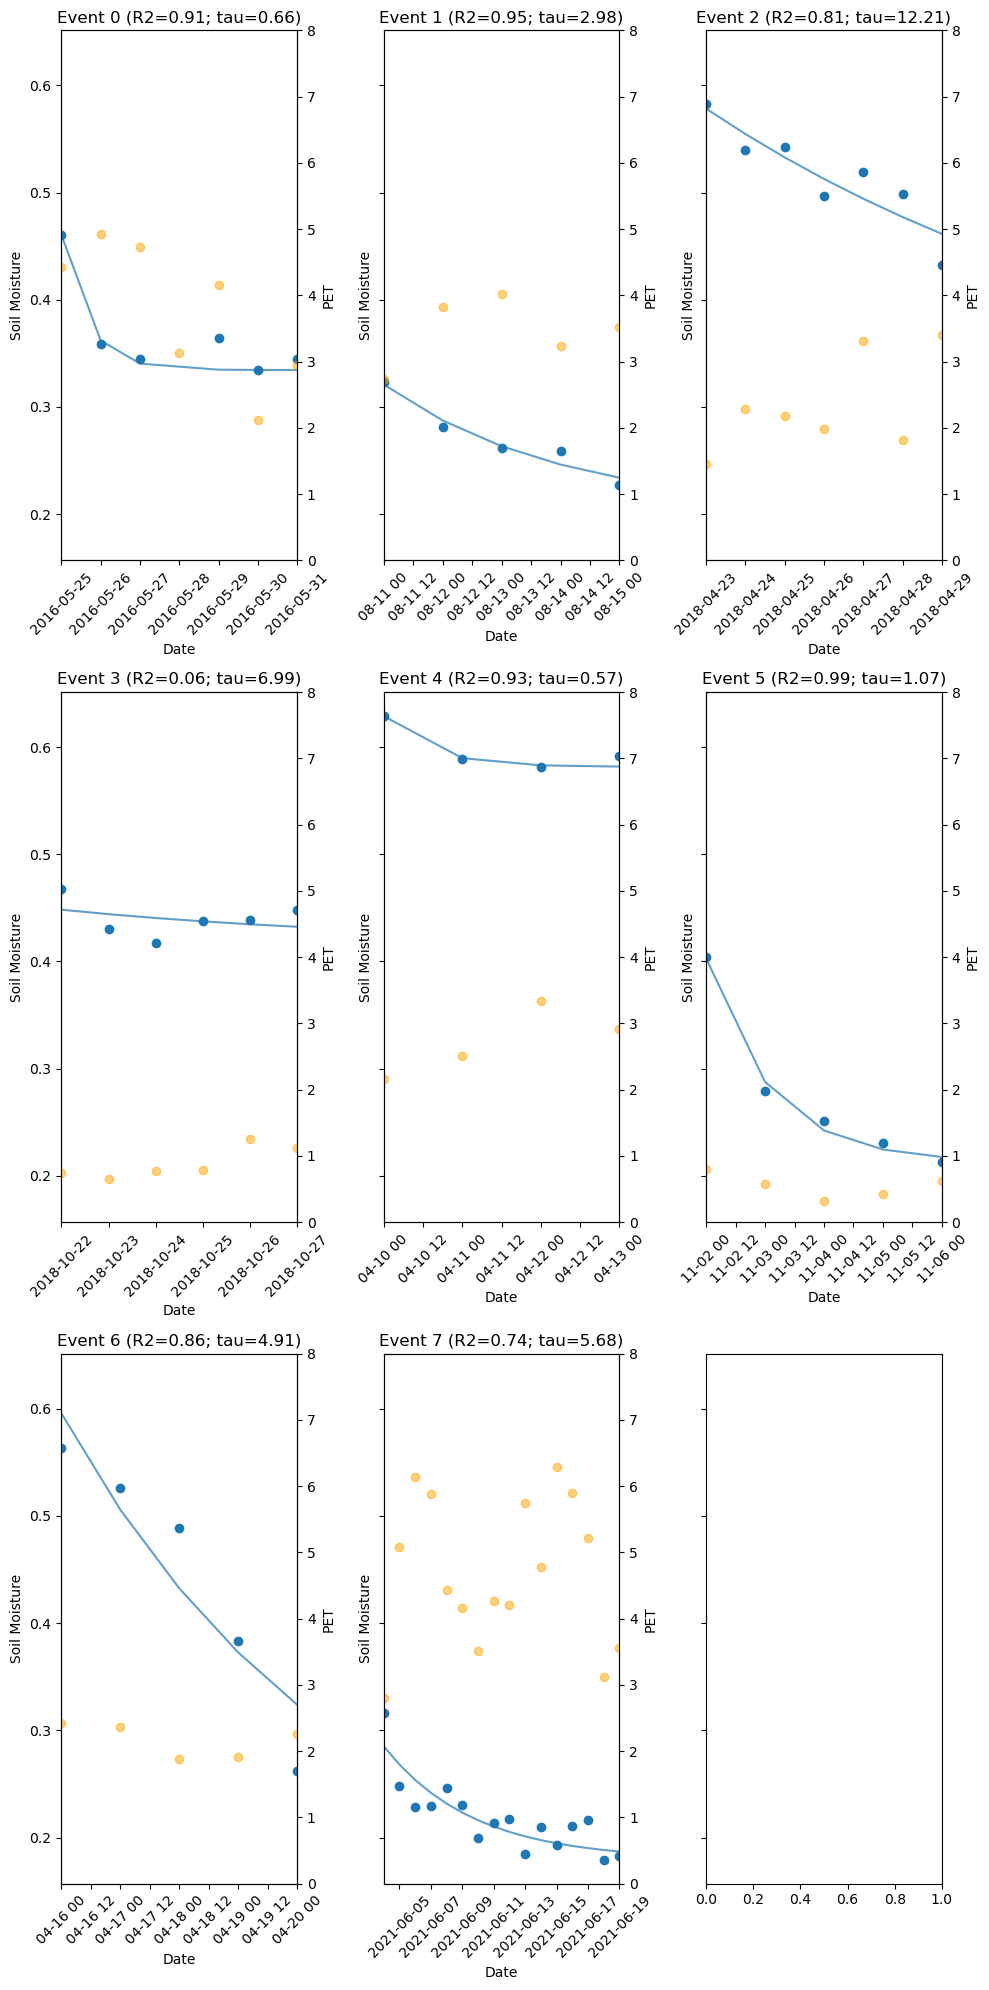

In [57]:
# Convert the event start/end columns to datetime format
event_df_with_curvefit['event_start'] = pd.to_datetime(event_df_long['event_start'])
event_df_with_curvefit['event_end'] = pd.to_datetime(event_df_long['event_end'])

# Determine the number of columns needed for the subplots grid
num_events = len(event_df_with_curvefit)
num_cols = 3
num_rows = int(num_events / num_cols) + int(num_events % num_cols != 0)

# Plot each row of the event DataFrame as a time series
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, sharey=True, figsize=(10, 20))
for index, row in event_df_with_curvefit.iterrows():

    x = pd.date_range(start=row['event_start'], end=row['event_end'], freq='D')
    y = np.asarray(row['soil_moisture_daily'])
    y_opt = np.asarray(row['opt_drydown'])
    y2 = row['PET']
    t = np.arange(0, len(row['soil_moisture_daily']),1)
    r_squared = row['r_squared']
    tau = row['tau']
    try:
        ax_row = int(index / num_cols)
        ax_col = index % num_cols
        axes[ax_row, ax_col].scatter(x, y)
        axes[ax_row, ax_col].plot(x[~np.isnan(y)], y_opt, alpha=.7)
        ax2 = axes[ax_row, ax_col].twinx()
        ax2.scatter(x, y2, color='orange', alpha=.5)
        axes[ax_row, ax_col].set_title(f'Event {index} (R2={r_squared:.2f}; tau={tau:.2f})')
        axes[ax_row, ax_col].set_xlabel('Date')
        axes[ax_row, ax_col].set_ylabel('Soil Moisture')
        axes[ax_row, ax_col].set_xlim([row['event_start'], row['event_end']])
        ax2.set_ylim([0, 8])
        ax2.set_ylabel('PET')
        # Rotate the x tick labels
        axes[ax_row, ax_col].tick_params(axis='x', rotation=45)
    except:
        continue

fig.tight_layout()
fig.show()
fig.savefig(os.path.join(output_path2, f'{target_station}_events.png'))


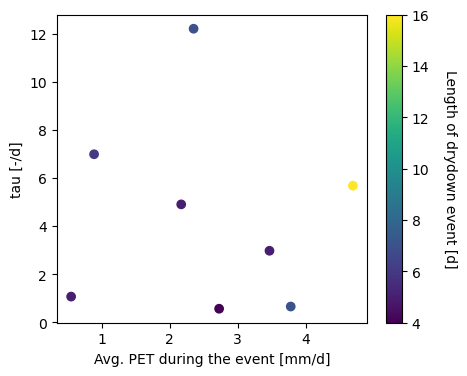

In [58]:
event_df_with_curvefit['mean_PET'] = event_df_with_curvefit['PET'].apply(np.mean)
event_df_with_curvefit['event_length'] = event_df_with_curvefit['PET'].apply(len)
fig, ax = plt.subplots(1,1, figsize=(5, 4))
sc = ax.scatter(event_df_with_curvefit['mean_PET'], event_df_with_curvefit['tau'], c=event_df_with_curvefit['event_length'])
ax.set_xlabel('Avg. PET during the event [mm/d]')
ax.set_ylabel('tau [-/d]')
cbar = fig.colorbar(sc)
cbar.ax.set_ylabel('Length of drydown event [d]', rotation=270, labelpad=20)
fig.savefig(os.path.join(output_path2, f'{target_station}_tau_vs_PET.png'))

In [549]:
event_df_with_curvefit.to_csv(os.path.join(home_dir, output_path2, 'event_df_with_curvefit.csv'), index=True)